In [1]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
#with open("../../config.yaml", "r") as f:
#    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]


In [2]:
fees_df = dt.get_territory_post_fee_histories()
posts_df = dt.get_posts()

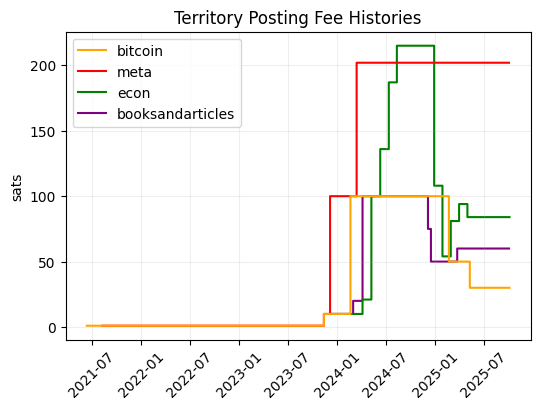

In [3]:
subs = ['bitcoin', 'meta', 'econ', 'booksandarticles']
colors = ['orange', 'red', 'green', 'purple']

plt.figure(figsize=(6,4))
for i in range(len(subs)):
    sub = subs[i]
    color = colors[i]
    zorder = 3 - i
    x = fees_df.loc[fees_df['subName']==sub, 'date']
    y = fees_df.loc[fees_df['subName']==sub, 'posting_fee']
    plt.step(x, y, where='post', label=sub, color=color, zorder=zorder)

plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.2)
plt.ylabel('sats')
plt.title("Territory Posting Fee Histories")
plt.show()

In [4]:
spells_df = []
curr_subName = fees_df.at[0, 'subName']
curr_fee = fees_df.at[0, 'posting_fee']
curr_start_date = fees_df.at[0, 'date']

fees_df = fees_df.sort_values(by=['subName', 'date'], ascending=True).reset_index(drop=True)
for idx in range(1, len(fees_df)):
    subName = fees_df.at[idx, 'subName']
    fee = fees_df.at[idx, 'posting_fee']
    date = fees_df.at[idx, 'date']
    if (subName != curr_subName):
        spells_df.append({
            'subName': curr_subName,
            'posting_fee': curr_fee,
            'start_date': curr_start_date,
            'end_date': globals.data_end.date()
        })
        curr_subName = subName
        curr_fee = fee
        curr_start_date = date
        continue
    if (fee != curr_fee):
        spells_df.append({
            'subName': curr_subName,
            'posting_fee': curr_fee,
            'start_date': curr_start_date,
            'end_date': date
        })
        curr_fee = fee
        curr_start_date = date
        continue
spells_df.append({
    'subName': curr_subName,
    'posting_fee': curr_fee,
    'start_date': curr_start_date,
    'end_date': globals.data_end.date()
})

spells_df = pd.DataFrame(spells_df)
spells_df['num_days'] = (spells_df['end_date'] - spells_df['start_date'])/pd.Timedelta(days=1)

spells_df['num_posts'] = 0
for idx, row in spells_df.iterrows():
    subName = row['subName']
    start_date = row['start_date']
    end_date = row['end_date']
    mask = (posts_df['created_at'].dt.date>=start_date) & (posts_df['created_at'].dt.date<end_date) & (posts_df['subName']==subName)
    num_posts = mask.sum()
    spells_df.at[idx, 'num_posts'] = num_posts

spells_df['posts_per_day'] = spells_df['num_posts'] / spells_df['num_days']

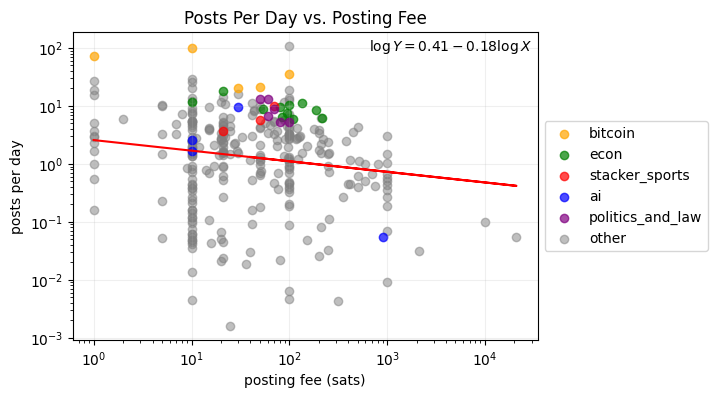

In [5]:
x = spells_df['posting_fee']
y = spells_df['posts_per_day']
logx = np.log10(x)
logy = np.log10(y)
X = sm.add_constant(logx)
model = sm.OLS(logy, X, missing='drop').fit()
logyhat = model.predict(X)
plt.figure(figsize=(6,4))

subs = ['bitcoin', 'econ', 'stacker_sports', 'ai', 'politics_and_law']
colors = ['orange', 'green', 'red', 'blue', 'purple']
for i in range(len(subs)):
    myx = spells_df.loc[spells_df['subName']==subs[i], 'posting_fee']
    myy = spells_df.loc[spells_df['subName']==subs[i], 'posts_per_day']
    plt.scatter(myx, myy, alpha=0.7, color=colors[i], label=subs[i])
myx = spells_df.loc[~spells_df['subName'].isin(subs), 'posting_fee']
myy = spells_df.loc[~spells_df['subName'].isin(subs), 'posts_per_day']
plt.scatter(myx, myy, alpha=0.5, color='gray', zorder=0, label='other')
plt.plot(x, np.power(10, logyhat), color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('posts per day')
plt.xlabel('posting fee (sats)')
plt.text(30000, 90, fr'$\log Y = {model.params.iloc[0]:.2f} - {np.abs(model.params.iloc[1]):.2f} \log X$', ha='right')
plt.title('Posts Per Day vs. Posting Fee')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(alpha=0.2)